In [20]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
import re
import pymorphy2
import string
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.utils import shuffle, resample
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## **Предобработка**

In [1]:
# читаем данные из файла
f = 'train_data_exam_1.xlsx'

df = pd.read_excel(f, 0)  
print('Dataset size', df.shape)
num_rows, num_feature = df.shape
print('row number: ', num_rows)
print('feature number: ', num_feature)
print()
print('names of features: ', list(df))
print('-------------------')
print('full data loaded')
print('-------------------')

Dataset size (18779, 2)
row number:  18779
feature number:  2

names of features:  ['original_data', 'score']
-------------------
full data loaded
-------------------


In [3]:
# уменьшим датасет за счет процедуры сэмплирования
rslt_df = df.sample(frac=0.15, replace=True, random_state=1) 

In [4]:
print(rslt_df.head(10))

                                           original_data  score
235    Можно или научить основам и работе с документа...      0
12172  сли А*Б меньше чем экономия на налогах - налог...     -1
5192   Очень приятно, что вы заметили фото.  Зато тет...     -1
17289  НЕСТЕРОВ Роман Андреевич –  следователь по осо...     -1
10955  я сам не более чем на 89 согласен  точно! _) э...     -1
7813   ли лягушачьи лапки. Или там работали сплошные ...      0
144    Россия - побежденный геополитический конкурент...     -1
16332  тем более, такой мелкий инфоповод. нет же. гру...     -2
7751   ва мощных взрыва прогремели в понедельник у фи...     -1
10989  арод, это лишь множество отдельных людей. Нет ...      0


In [5]:
# востановим индексы
newdf =rslt_df.reset_index()
print('Dataset size', newdf.shape)
num_rows, num_feature =newdf.shape

Dataset size (2817, 3)


In [6]:
morph = pymorphy2.MorphAnalyzer()

start = time.time()
y_data = []
for i in tqdm(range(num_rows)):
    s = str(newdf['original_data'][i])
    s1 = re.sub(r"[,.?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', s)
    tokens = word_tokenize(s1)
    doc_stem=''
    for j in range(0,len(tokens)):
        tokens[j] = morph.parse(tokens[j])[0].normal_form
        doc_stem = doc_stem + tokens[j] + ' '
    
    y_data.append(doc_stem)

stop = time.time()    

print('time of execution (sec)', stop - start)

100%|██████████| 2817/2817 [01:21<00:00, 34.48it/s]

time of execution (sec) 81.69951391220093


In [7]:
from nltk.corpus import stopwords
words = stopwords.words("russian")

print('Vectorization of documents')
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range=(1,1),stop_words=(words))

data = vec.fit_transform(y_data).toarray()

num_docs, num_feature =data.shape
print('documents number : ', num_docs, 'feature number: ', num_feature)

Vectorization of documents
documents number :  2817 feature number:  35903


In [8]:
with open('vectorizer15.pk', 'wb') as fin:
    pickle.dump(vec, fin)

In [9]:
vectorizer = pickle.load(open("vectorizer15.pk", "rb"))
data = vectorizer.fit_transform(y_data).toarray()
num_docs, num_feature =data.shape
print('documents number : ', num_docs, 'feature number: ', num_feature)

documents number :  2817 feature number:  35903


In [10]:
newdata = pd.DataFrame(data=data)
print(newdata.shape)
newdata = pd.concat([newdata, newdf['score']], axis=1)
print('итоговый размер: ', newdata.shape)
newdata.head(1)

(2817, 35903)
итоговый размер:  (2817, 35904)


,0,1,2,3,4,5,6,7,8,9,...,35894,35895,35896,35897,35898,35899,35900,35901,35902,score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
# upsampling
#  выделим строки с определеными классами
neut_df= newdata[newdata['score'] == 0]
neg_df= newdata[newdata['score'] == -1]
pos_df= newdata[newdata['score'] == 1]
super_neg_df = newdata[newdata['score'] == -2]
super_pos_df= newdata[newdata['score'] == 2]

In [12]:
print(neut_df.shape)
print(neg_df.shape)
print(pos_df.shape)
print(super_neg_df.shape)
print(super_pos_df.shape)

(1471, 35904)
(970, 35904)
(187, 35904)
(152, 35904)
(37, 35904)


In [13]:
from sklearn.utils import resample
print('neg_dataset before sampling: ', neg_df.shape)

neg_downsample = resample(neg_df,
             replace=True,
             n_samples=1471,
             random_state=42)

print('neg_dataset after sampling: ', neg_downsample.shape)

neg_dataset before sampling:  (970, 35904)
neg_dataset after sampling:  (1471, 35904)


In [14]:
print('pos_dataset before sampling: ', pos_df.shape)

pos_downsample = resample(pos_df,
             replace=True,
             n_samples=1471,
             random_state=42)

print('pos_dataset after sampling: ', pos_downsample.shape)

pos_dataset before sampling:  (187, 35904)
pos_dataset after sampling:  (1471, 35904)


In [15]:
print('super_neg_dataset before sampling: ', super_neg_df.shape)

super_neg_downsample = resample(super_neg_df,
             replace=True,
             n_samples=1471,
             random_state=42)

print('super_neg_dataset after sampling: ', super_neg_downsample.shape)

super_neg_dataset before sampling:  (152, 35904)
super_neg_dataset after sampling:  (1471, 35904)


In [16]:
print('super_pos_dataset before sampling: ', super_pos_df.shape)

super_pos_downsample = resample(super_pos_df,
             replace=True,
             n_samples=1471,
             random_state=42)

print('neg_dataset after sampling: ', super_pos_downsample.shape)

super_pos_dataset before sampling:  (37, 35904)
neg_dataset after sampling:  (1471, 35904)


In [17]:
full_up_sample = pd.concat([super_neg_downsample, neg_downsample, neut_df, pos_downsample, super_pos_downsample])
print(full_up_sample.shape)

(7355, 35904)


In [21]:
Y = full_up_sample['score'].values
X = full_up_sample[full_up_sample.columns[:-1]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Test collection size: ', X_test.shape)
print('Training collection size: ', X_train.shape)

Test collection size:  (1471, 35903)
Training collection size:  (5884, 35903)


In [29]:
full_up_sample.shape

(7355, 35904)

## **Модели**

In [35]:
n_estimators = [10, 100, 200]
max_features = ['sqrt', 'log2']
max_depth = [5, 7, 10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

In [36]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

print(random_grid)

{'n_estimators': [10, 100, 200], 'max_features': ['sqrt', 'log2'], 'max_depth': [5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [37]:
start = time.time()   

myRF = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='log2',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced')

mycv = ShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

clf = GridSearchCV(myRF, random_grid, cv=mycv)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)
stop = time.time()    

print('time of execution (sec)', stop - start)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.8519252548131371
time of execution (sec) 11846.082142591476


{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.8519252548131371
time of execution (sec) 11846.082142591476

In [33]:
my_label=clf.predict(X_test)

              precision    recall  f1-score   support

          -2       0.99      0.98      0.99       310
          -1       0.96      0.76      0.85       286
           0       0.81      0.94      0.87       303
           1       0.96      1.00      0.98       290
           2       0.99      1.00      0.99       282

    accuracy                           0.94      1471
   macro avg       0.94      0.94      0.94      1471
weighted avg       0.94      0.94      0.94      1471

[[305   0   0   5   0]
 [  4 216  66   0   0]
 [  0   9 284   7   3]
 [  0   0   0 290   0]
 [  0   0   0   0 282]]


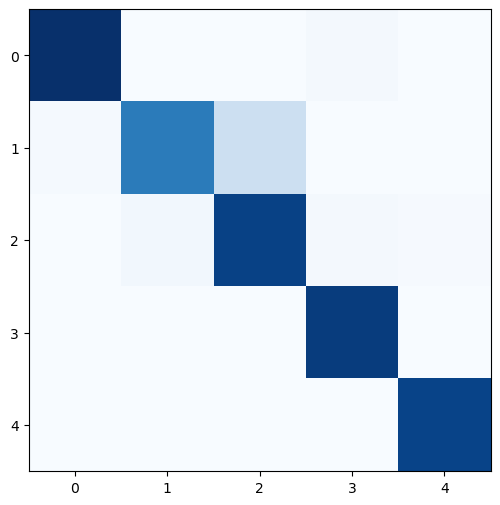

In [34]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(y_test, my_label, zero_division=0))
print(metrics.confusion_matrix(y_test, my_label))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(y_test, my_label), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6)    
plt.show()

In [38]:
with open("model_up_RF15.pkl", "wb") as f:
    pickle.dump(clf, f)

In [41]:
knn = KNeighborsClassifier()

start = time.time() 
param_grid = [ {'n_neighbors': [1, 3, 7], 'weights': ['uniform','distance'], 'p': [1,2], 
                'algorithm' :['ball_tree', 'kd_tree', 'brute' ]} ]

mycv = ShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
clf = GridSearchCV(knn, param_grid, cv=mycv , scoring='f1_macro')

clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)
stop = time.time()    

print('time of execution (sec)', stop - start)

{'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.9114252547443389
time of execution (sec) 15373.197498559952


{'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.9114252547443389
time of execution (sec) 15373.197498559952

In [ ]:
my_label=clf.predict(X_test)

In [ ]:
# сравним полученный результат с известными ответами
# вывод качества построенной модели
print(metrics.classification_report(y_test, my_label, zero_division=0))
print(metrics.confusion_matrix(y_test, my_label))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(y_test, my_label), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6)    
plt.show()

In [42]:
with open("my_modelKNN15.pkl", "wb") as f:
    pickle.dump(clf, f)

In [23]:
start = time.time()   

random_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
mySVM = SVC(gamma="scale")
mycv = ShuffleSplit(n_splits=2, test_size=0.3, random_state=0)

clf = GridSearchCV(mySVM, random_grid, cv=mycv)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)
stop = time.time()    

print('time of execution (sec)', stop - start)

{'C': 100, 'kernel': 'linear'}
0.8997734994337485
time of execution (sec) 13839.967208623886


In [24]:
with open("my_modelSVM15.pkl", "wb") as f:
    pickle.dump(clf, f)

In [25]:
my_label=clf.predict(X_test)

              precision    recall  f1-score   support

          -2       0.99      0.98      0.99       310
          -1       0.84      0.83      0.84       286
           0       0.85      0.83      0.84       303
           1       0.96      1.00      0.98       290
           2       1.00      1.00      1.00       282

    accuracy                           0.93      1471
   macro avg       0.93      0.93      0.93      1471
weighted avg       0.93      0.93      0.93      1471

[[305   0   0   5   0]
 [  4 238  44   0   0]
 [  0  44 251   7   1]
 [  0   0   0 290   0]
 [  0   0   0   0 282]]


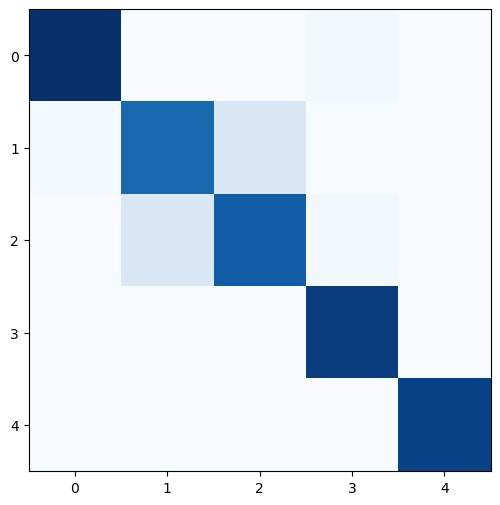

In [26]:
print(metrics.classification_report(y_test, my_label, zero_division=0))
print(metrics.confusion_matrix(y_test, my_label))

%matplotlib inline
fig, ax = plt.subplots()
cmap=plt.cm.Blues
ax.imshow(metrics.confusion_matrix(y_test, my_label), cmap=cmap)
fig.set_figwidth(6)    
fig.set_figheight(6)     
plt.show()

## Тестирование

In [6]:
# читаем данные из файла
f = 'test_data_exam_1.xlsx'
df1 = pd.read_excel(f, 0)  
print('Dataset size', df1.shape)
num_rows, num_feature = df1.shape

print('row number: ', num_rows)
print('feature number: ', num_feature)
print()
print('names of features: ', list(df1))

print('-------------------')
print('full data loaded')
print('-------------------')

Dataset size (8048, 2)
row number:  8048
feature number:  2

names of features:  ['original_data', 'score']
-------------------
full data loaded
-------------------


In [8]:
morph = pymorphy2.MorphAnalyzer()

start = time.time()

y_data1 = []
for i in tqdm(range(num_rows)):
    s = str(df1['original_data'][i])
    s1 = re.sub(r"[,.?“/!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”*°°*`)(]", '', s)
    tokens = word_tokenize(s1)
    doc_stem=''
    for j in range(0,len(tokens)):
        tokens[j] = morph.parse(tokens[j])[0].normal_form
        doc_stem = doc_stem + tokens[j] + ' '
    
    y_data1.append(doc_stem)

stop = time.time()    

print('time of execution (sec)', stop - start)

100%|██████████| 8048/8048 [03:47<00:00, 35.39it/s]

time of execution (sec) 227.39617896080017


In [12]:
vectorizer = pickle.load(open("vectorizer15.pk", "rb"))

In [14]:
print('Vectorization of documents')

data1 = vectorizer.transform(y_data1).toarray()

num_docs, num_feature =data1.shape
print('documents number : ', num_docs, 'feature number: ', num_feature)

Vectorization of documents
documents number :  8048 feature number:  35903


In [16]:
newdata1 = pd.DataFrame(data=data1)
print(newdata1.shape)
newdata1 = pd.concat([newdata1, df1['score']], axis=1)
print('итоговый размер: ', newdata1.shape)

# upsampling
#  выделим строки с определеными классами
neut_df1= newdata1[newdata1['score'] == 0]
neg_df1= newdata1[newdata1['score'] == -1]
pos_df1= newdata1[newdata1['score'] == 1]
super_neg_df1 = newdata1[newdata1['score'] == -2]
super_pos_df1= newdata1[newdata1['score'] == 2]

print(neut_df1.shape)
print(neg_df1.shape)
print(pos_df1.shape)
print(super_neg_df1.shape)
print(super_pos_df1.shape)


(8048, 35903)
итоговый размер:  (8048, 35904)
(4199, 35904)
(2747, 35904)
(524, 35904)
(473, 35904)
(105, 35904)


In [18]:
print('neg_dataset before sampling: ', neg_df1.shape)

neg_downsample = resample(neg_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('neg_dataset after sampling: ', neg_downsample.shape)

print('pos_dataset before sampling: ', pos_df1.shape)

pos_downsample = resample(pos_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('pos_dataset after sampling: ', pos_downsample.shape)

print('super_neg_dataset before sampling: ', super_neg_df1.shape)

super_neg_downsample = resample(super_neg_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('super_neg_dataset after sampling: ', super_neg_downsample.shape)

print('super_pos_dataset before sampling: ', super_pos_df1.shape)

super_pos_downsample = resample(super_pos_df1,
             replace=True,
             n_samples=4199,
             random_state=42)

print('neg_dataset after sampling: ', super_pos_downsample.shape)


neg_dataset before sampling:  (2747, 35904)
neg_dataset after sampling:  (4199, 35904)
pos_dataset before sampling:  (524, 35904)
pos_dataset after sampling:  (4199, 35904)
super_neg_dataset before sampling:  (473, 35904)
super_neg_dataset after sampling:  (4199, 35904)
super_pos_dataset before sampling:  (105, 35904)
neg_dataset after sampling:  (4199, 35904)


In [9]:
full_up_sample = pd.concat([super_neg_downsample, neg_downsample, neut_df1, pos_downsample, super_pos_downsample])
print(full_up_sample.shape)

(20995, 35904)


In [11]:
Y = full_up_sample['score'].values
X = full_up_sample[full_up_sample.columns[:-1]].to_numpy()

In [10]:
with open("model_up_RF15.pkl", "rb") as f:
    modelRF15 = pickle.load(f)

In [12]:
predictedRF = modelRF15.predict(X)
print(metrics.classification_report(Y, predictedRF, zero_division=0))
print(metrics.confusion_matrix(Y, predictedRF))

              precision    recall  f1-score   support

          -2       0.61      0.19      0.29      4199
          -1       0.27      0.39      0.32      4199
           0       0.25      0.62      0.36      4199
           1       0.38      0.25      0.30      4199
           2       0.86      0.10      0.18      4199

    accuracy                           0.31     20995
   macro avg       0.47      0.31      0.29     20995
weighted avg       0.47      0.31      0.29     20995

[[ 788 1407 1861  120   23]
 [ 239 1632 2052  269    7]
 [ 124 1131 2623  306   15]
 [ 147  961 2032 1032   27]
 [   0 1007 1790  976  426]]


In [13]:
with open("my_modelKNN15.pkl", "rb") as f:
    modelKNN15 = pickle.load(f)

In [29]:
predictedKNN = modelKNN15.predict(X)
print(metrics.classification_report(Y, predictedKNN, zero_division=0))
print(metrics.confusion_matrix(Y, predictedKNN))

              precision    recall  f1-score   support

          -2       0.83      0.15      0.25      4199
          -1       0.48      0.11      0.18      4199
           0       0.22      0.94      0.36      4199
           1       0.64      0.14      0.23      4199
           2       0.87      0.09      0.17      4199

    accuracy                           0.29     20995
   macro avg       0.61      0.29      0.24     20995
weighted avg       0.61      0.29      0.24     20995

[[ 614  180 3351   41   13]
 [  77  463 3617   36    6]
 [  23  156 3939   67   14]
 [   0   73 3507  592   27]
 [  28   87 3499  191  394]]


In [37]:
with open("my_modelSVM15.pkl", "rb") as f:
    modelSVM = pickle.load(f)

In [38]:
Y = df1['score'].values

In [39]:
from sklearn import metrics

predictedRF = modelSVM.predict(data1)
print(metrics.classification_report(Y, predictedRF, zero_division=0))
print(metrics.confusion_matrix(Y, predictedRF))

              precision    recall  f1-score   support

          -2       0.43      0.15      0.22       473
          -1       0.47      0.41      0.44      2747
           0       0.60      0.74      0.66      4199
           1       0.40      0.19      0.26       524
           2       0.44      0.11      0.18       105

    accuracy                           0.55      8048
   macro avg       0.47      0.32      0.35      8048
weighted avg       0.53      0.55      0.53      8048

[[  71  187  209    5    1]
 [  62 1137 1516   30    2]
 [  31  938 3127   94    9]
 [   1  115  305  100    3]
 [   2   19   52   20   12]]
